# PIC-SURE API use-case: quick analysis on CIBMTR data

This is a tutorial notebook aimed to get the user quickly up and running with the R PIC-SURE API. It covers the main functionalities of the API.

## PIC-SURE R API
### What is PIC-SURE?

As part of the BioData Catalyst initiative, the Patient Information Commons Standard Unification of Research Elements (PIC-SURE) platform has been integrating clinical and genomic datasets from multiple TOPMed and TOPMed related studies funded by the National Heart Lung and Blood Institute (NHLBI).

Original data exposed through the PIC-SURE API encompasses a large heterogeneity of data organization underneath. PIC-SURE hides this complexity and exposes the different study datasets in a single tabular format. By simplifying the process of data extraction, it allows investigators to focus on the downstream analyses and to facilitate reproducible sciences.


### More about PIC-SURE
The API is available in two different programming languages, python and R, enabling investigators to query the databases the same way using either language.


PIC-SURE is a larger project from which the R/python PIC-SURE API is only a brick. Among other things, PIC-SURE also offers a graphical user interface that allows researchers to explore variables across multiple studies, filter patients that match criteria, and create cohorts from this interactive exploration.

The R API is actively developed by the Avillach Lab at Harvard Medical School.

PIC-SURE API GitHub repo:
* https://github.com/hms-dbmi/pic-sure-r-adapter-hpds
* https://github.com/hms-dbmi/pic-sure-r-client
* https://github.com/hms-dbmi/pic-sure-biodatacatalyst-r-adapter-hpds




 -------   

# Getting your own user-specific security token

**Before running this notebook, please be sure to review the "Get your security token" documentation, which exists in the NHLBI_BioData_Catalyst [README.md file](https://github.com/hms-dbmi/Access-to-Data-using-PIC-SURE-API/tree/master/NHLBI_BioData_Catalyst#get-your-security-token). It explains about how to get a security token, which is mandatory to access the databases.**

# Environment set-up

### Pre-requisites
- R 3.4 or later

### Install packages

Install the following:
- packages listed in the `requirements.R` file
- PIC-SURE API components (from Github)
    - PIC-SURE Adapter
    - PIC-SURE Client

In [1]:
source("R_lib/requirements.R")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘credentials’, ‘zip’, ‘gitcreds’, ‘ini’, ‘gert’, ‘gh’, ‘whisker’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



installing: 
-  ggplot2 
-  dplyr 
-  tidyr 
-  urltools 
-  devtools 
-  ggrepel 


also installing the dependencies ‘systemfonts’, ‘textshaping’, ‘xopen’, ‘brew’, ‘rex’, ‘crosstalk’, ‘clisymbols’, ‘cyclocomp’, ‘xmlparsedata’, ‘downlit’, ‘ragg’, ‘parsedate’, ‘whoami’, ‘hunspell’, ‘memoise’, ‘pkgbuild’, ‘rcmdcheck’, ‘remotes’, ‘roxygen2’, ‘rversions’, ‘sessioninfo’, ‘BiocManager’, ‘covr’, ‘DT’, ‘foghorn’, ‘gmailr’, ‘lintr’, ‘mockery’, ‘pingr’, ‘pkgdown’, ‘rhub’, ‘spelling’


Warning message in install.packages(package, dependencies = TRUE):
“installation of package ‘systemfonts’ had non-zero exit status”
Warning message in install.packages(package, dependencies = TRUE):
“installation of package ‘textshaping’ had non-zero exit status”
Warning message in install.packages(package, dependencies = TRUE):
“installation of package ‘ragg’ had non-zero exit status”
Warning message in install.packages(package, dependencies = TRUE):
“installation of package ‘pkgdown’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also in

In [2]:
Sys.setenv(TAR = "/bin/tar")
options(unzip = "internal")
install.packages("https://cran.r-project.org/src/contrib/R6_2.5.0.tar.gz", repos=NULL, type="source")
install.packages("https://cran.r-project.org/src/contrib/hash_2.2.6.1.tar.gz", repos=NULL, type="source")
devtools::install_github("hms-dbmi/pic-sure-r-client", force=T)
devtools::install_github("hms-dbmi/pic-sure-r-adapter-hpds", force=T)
devtools::install_github("hms-dbmi/pic-sure-biodatacatalyst-r-adapter-hpds", force=T)


✔  checking for file ‘/tmp/Rtmp0XmOla/remotes60703b62a72d/hms-dbmi-pic-sure-r-client-115deb5/DESCRIPTION’
─  preparing ‘picsure’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘picsure_0.1.0.tar.gz’
   



✔  checking for file ‘/tmp/Rtmp0XmOla/remotes6070292436a9/hms-dbmi-pic-sure-r-adapter-hpds-2cee5ee/DESCRIPTION’
─  preparing ‘hpds’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘hpds_0.1.1.tar.gz’
   



✔  checking for file ‘/tmp/Rtmp0XmOla/remotes60702c12cb51/hms-dbmi-pic-sure-biodatacatalyst-r-adapter-hpds-d019468/DESCRIPTION’
─  preparing ‘bdc’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘bdc_0.1.0.tar.gz’
   


##### Loading user-defined functions

In [3]:
source("R_lib/utils.R")

## Connecting to a PIC-SURE resource

The following is required to get access to data through the PIC-SURE API: 
- Network URL
- Resource id
- User-specific security token

If you have not already retrieved your user-specific token, please refer to the "Get your security token" section of the [README.md](https://github.com/hms-dbmi/Access-to-Data-using-PIC-SURE-API/tree/master/NHLBI_BioData_Catalyst#get-your-security-token) file.

In [4]:
# Set required information as variables
PICSURE_network_URL <- "https://biodatacatalyst.integration.hms.harvard.edu/picsure"
#PICSURE_network_URL <- "https://picsure.biodatacatalyst.nhlbi.nih.gov/picsure"
resource_id <- "02e23f52-f354-4e8b-992c-d37c8b9ba140"
token_file <- "token.txt"

In [5]:
token <- scan(token_file, what = "character")

In [6]:
# Establish connection to PIC-SURE
connection <- picsure::connect(url = PICSURE_network_URL,
                                 token = token)

[1] "02e23f52-f354-4e8b-992c-d37c8b9ba140"
[2] "70c837be-5ffc-11eb-ae93-0242ac130002"


In [7]:
# it may take several minutes to connect and download the initialization data
resource <- bdc::get.resource(connection,
                               resourceUUID = resource_id)

[1] "Loading data dictionary... (takes a minute)"


Two objects are created here: a `connection` and a `resource` object.

Since we will only be using a single resource, **the `resource` object is actually the only one we will need to proceed with data analysis hereafter**.

It is connected to the specific data source ID we specified and enables us to query and retrieve data from this database.

## Getting help with the R PIC-SURE API

You can get help with PIC-SURE library functions by using the `?` operator.

In [8]:
?bdc::get.resource()

## Using the *variables dictionary*

Once a connection to the desired resource has been established, we first need to understand which variables are available in the database. To this end, we will use the `find.in.dictionary` function.

For instance, looking for variables containing the term `Sickle Cell` is done this way:

In [9]:
dictionary_search <- bdc::find.in.dictionary(resource, "Sickle Cell")

Four different functions can be used to retrieve results from a dictionary search: `extract.count()`, `extract.keys()`, `extract.entries()`, and `extract.dataframe()`.

In [10]:
print(list("Count"   = bdc::extract.count(dictionary_search), 
           "Keys"    = bdc::extract.keys(dictionary_search)[1:2], # Show first two keys
           "Entries" = bdc::extract.entries(dictionary_search)[1:2])) # Show first two entries

$Count
[1] 170

$Keys
$Keys[[1]]
[1] "\\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\\5 - CRF data collection track only\\Time from HCT to pancreatitis, months\\"

$Keys[[2]]
[1] "\\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\\4 - Outcomes\\Death without graft failure\\"


$Entries
              min patientCount
2    4.276316e-01           10
210            NA         1518
3              NA         1518
4              NA          732
5              NA         1518
6              NA          732
7              NA          732
8              NA          732
9              NA          732
10   1.266447e+01            3
11   2.631579e-01         1363
12             NA          732
13             NA          732
14             NA         1518
15             NA          732
16   1.973684e-01           23
17   6.447368e+00            2
18             NA          732
19             NA         1518
20             NA     

In [11]:
bdc::extract.entries(dictionary_search) %>% tail() #View last entries as a dataframe

,min,patientCount,categorical,observationCount,max,name,HpdsDataType,categoryValues,description
,<dbl>,<int>,<lgl>,<int>,<dbl>,<chr>,<chr>,<list>,<lgl>
165,0.1,722,FALSE,722,1.5,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\Serum creatinine pre-conditioning\,phenotypes,NA,NA
166,NA,1518,TRUE,1518,NA,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\4 - Outcomes\Death without platelet recovery\,phenotypes,"No , Not Reported, Yes",NA
167,NA,732,TRUE,732,NA,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\Clinically significant fungal infection at any time pre-conditioning\,phenotypes,"No , Not reported, Yes",NA
168,NA,732,TRUE,732,NA,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\Anxiety requiring therapy\,phenotypes,"No , Not reported, Yes",NA
169,NA,1518,TRUE,1518,NA,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\4 - Outcomes\Secondary malignancy\,phenotypes,"Acute myelogenous leukemia , Central nervous system malignancy , Clonal cytogenetic abnormality: monosomy 7 , Clonal cytogenetic abnormality: unspecified, EBV lymphoma , Genitourinary malignancy , Myelodysplastic syndrome , Myofibroblastic tumor , None , Not Reported , Sarcoma , T-cell large granular lymphocyte leukemia , TP53 mutation",NA
170,NA,732,TRUE,732,NA,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\Intubation or mechanical ventilation for ACS pre-conditioning\,phenotypes,"N/A , No , Not reported, Yes",NA


**`bdc::extract.dataframe()` retrieves the result of the dictionary search in a data.frame format. This way, it enables us to:**

* Use the various information exposed in the dictionary (patientCount, variable type ...) as criteria for variable selection.
* Use the row names of the DataFrame to get the actual variables names, to be used in the query, as shown below.

Variable names, as currently implemented in the API, aren't very practical to use right away for two reasons:
1. Very long
2. Presence of backslashes that requires modification right after copy-pasting.

However, using the dictionary to select variables can help access the variable names. Let's say we want to retrieve every variable from the HCT for SCD dataset. One way to proceed is to retrieve the whole dictionary for those variables in the form of a data.frame, as below:

In [12]:
hctforscd_variablesDict <-  bdc::find.in.dictionary(resource, "HCT for SCD") %>% 
                            bdc::extract.entries()
hctforscd_variablesDict[1:5,]

,min,patientCount,categorical,observationCount,max,name,HpdsDataType,categoryValues,description
,<dbl>,<int>,<lgl>,<int>,<dbl>,<chr>,<chr>,<list>,<lgl>
2,0.4276316,10,FALSE,10,123.3882,"\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\Time from HCT to pancreatitis, months\",phenotypes,NA,NA
210,NA,1518,TRUE,1518,NA,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\4 - Outcomes\Death without graft failure\,phenotypes,"No , Not Reported, Yes",NA
3,NA,1518,TRUE,1518,NA,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\3 - Transplant Related\Conditioning intensity\,phenotypes,"Myeloablative , Non-myeloablative , Not Reported , Reduced-intensity conditioning",NA
4,NA,732,TRUE,732,NA,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\Other organ impairment or disorder\,phenotypes,"No , Not reported, Yes",NA
5,NA,1518,TRUE,1518,NA,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\1 - Patient Related\Cases from 2016 Blood publication\,phenotypes,"No , Yes",NA


*Note: Using* `bdc::find.in.dictionary` *function without any search terms returns every entry.*

The dictionary currently returned by the API provides information about the variables, such as:
- observationCount: number of entries with non-null value
- categorical: type of the variables, True if strings, False if numerical
- min/max: only provided for numerical variables
- HpdsDataType: 'phenotypes' or 'genotypes'. Currently, the API only exposes 'phenotypes' variables

### Extract full HCT for SCD data dictionary to CSV

Using the `bdc::find.in.dictionary` we can extact the entire data dictionary by searching for `HCT for SCD` and saving it to `fullVariablesDict`:

In [13]:
fullVariablesDict <- bdc::find.in.dictionary(resource, "HCT for SCD") %>%
                     bdc::extract.entries()
dim(fullVariablesDict)

[1] 155   9

Check that the `fullVariablesDict` dataframe contains some values.

In [14]:
fullVariablesDict[0:5,] # View first five rows

,min,patientCount,categorical,observationCount,max,name,HpdsDataType,categoryValues,description
,<dbl>,<int>,<lgl>,<int>,<dbl>,<chr>,<chr>,<list>,<lgl>
2,0.4276316,10,FALSE,10,123.3882,"\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\Time from HCT to pancreatitis, months\",phenotypes,NA,NA
210,NA,1518,TRUE,1518,NA,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\4 - Outcomes\Death without graft failure\,phenotypes,"No , Not Reported, Yes",NA
3,NA,1518,TRUE,1518,NA,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\3 - Transplant Related\Conditioning intensity\,phenotypes,"Myeloablative , Non-myeloablative , Not Reported , Reduced-intensity conditioning",NA
4,NA,732,TRUE,732,NA,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\Other organ impairment or disorder\,phenotypes,"No , Not reported, Yes",NA
5,NA,1518,TRUE,1518,NA,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\1 - Patient Related\Cases from 2016 Blood publication\,phenotypes,"No , Yes",NA


We can then write the data frame that contains the full HCT for SCD data dictionary to a csv file.

In [15]:
dataDictFile <- "data_dictionary_R.csv" # Name of output file
saveDictFrame <- fullVariablesDict[ , c("name", "patientCount", "min", "categorical", "observationCount", "max", "HpdsDataType", "description")]
write.csv(saveDictFrame, dataDictFile, row.names = FALSE)

You should now see a `data_dictionary_R.csv` in the Jupyter Hub file explorer, in the same folder as this notebook.

### Parsing variable names

We can use a simple function, `get_multiIndex_variablesDict`, defined in `R_lib/utils.R` to add a little more information to the variable dictionary and to simplify working with variables names.

Although not an official feature of the API, such functionality illustrates how to quickly select groups of related variables.

Printing part of the parsed names dictionary allows us to quickly see the tree-like organization of the variable names. Moreover, original and simplified variable names are now stored respectively in the `varName` and `simplified_varName` columns (simplified variable names is simply the last component of the variable name, that is usually the most informative to know what each variable is about).

In [16]:
# Display the variables tree hierarchy from the variables name
variablesDict <- get_multiIndex_variablesDict(hctforscd_variablesDict)
head(variablesDict)

level_0,level_1,level_2,simplified_name,name,observationCount,categorical,categoryValues,min,max,HpdsDataType
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<lgl>,<list>,<dbl>,<dbl>,<chr>
Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 ),5 - CRF data collection track only,"Time from HCT to pancreatitis, months","Time from HCT to pancreatitis, months","\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\Time from HCT to pancreatitis, months\",10,FALSE,NA,0.4276316,123.3882,phenotypes
Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 ),4 - Outcomes,Death without graft failure,Death without graft failure,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\4 - Outcomes\Death without graft failure\,1518,TRUE,"No , Not Reported, Yes",NA,NA,phenotypes
Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 ),3 - Transplant Related,Conditioning intensity,Conditioning intensity,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\3 - Transplant Related\Conditioning intensity\,1518,TRUE,"Myeloablative , Non-myeloablative , Not Reported , Reduced-intensity conditioning",NA,NA,phenotypes
Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 ),5 - CRF data collection track only,Other organ impairment or disorder,Other organ impairment or disorder,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\Other organ impairment or disorder\,732,TRUE,"No , Not reported, Yes",NA,NA,phenotypes
Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 ),1 - Patient Related,Cases from 2016 Blood publication,Cases from 2016 Blood publication,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\1 - Patient Related\Cases from 2016 Blood publication\,1518,TRUE,"No , Yes",NA,NA,phenotypes
Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 ),5 - CRF data collection track only,Diabetes/hyperglycemia requiring chronic treatment,Diabetes/hyperglycemia requiring chronic treatment,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\Diabetes/hyperglycemia requiring chronic treatment\,732,TRUE,"No , Not reported, Yes",NA,NA,phenotypes


Below is a simple example to illustrate the ease of use a multiIndex dictionary. Let's say we are interested in the variables within the "5 - CRF data collection track only" of the "Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )" study.

In [17]:
# Find studies that match the name of interest
mask_study <- variablesDict[,1] == "Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )"
# Find CRF data collection track only variable names
mask_dctrack <- grepl("5 - CRF data collection track only", variablesDict[["level_1"]])
# Filter to the variables
filter_variables <- variablesDict[mask_study & mask_dctrack,]
filter_variables

level_0,level_1,level_2,simplified_name,name,observationCount,categorical,categoryValues,min,max,HpdsDataType
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<lgl>,<list>,<dbl>,<dbl>,<chr>
Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 ),5 - CRF data collection track only,"Time from HCT to pancreatitis, months","Time from HCT to pancreatitis, months","\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\Time from HCT to pancreatitis, months\",10,FALSE,NA,0.4276316,123.3881579,phenotypes
Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 ),5 - CRF data collection track only,Other organ impairment or disorder,Other organ impairment or disorder,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\Other organ impairment or disorder\,732,TRUE,"No , Not reported, Yes",NA,NA,phenotypes
Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 ),5 - CRF data collection track only,Diabetes/hyperglycemia requiring chronic treatment,Diabetes/hyperglycemia requiring chronic treatment,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\Diabetes/hyperglycemia requiring chronic treatment\,732,TRUE,"No , Not reported, Yes",NA,NA,phenotypes
Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 ),5 - CRF data collection track only,Did TMA resolve?,Did TMA resolve?,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\Did TMA resolve?\,732,TRUE,"N/A , No , Not reported, Yes",NA,NA,phenotypes
Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 ),5 - CRF data collection track only,VOD post-HCT,VOD post-HCT,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\VOD post-HCT\,732,TRUE,"No , Yes",NA,NA,phenotypes
Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 ),5 - CRF data collection track only,Liver biopsy performed pre-conditioning,Liver biopsy performed pre-conditioning,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\Liver biopsy performed pre-conditioning\,732,TRUE,"No , Not reported, Yes",NA,NA,phenotypes
Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 ),5 - CRF data collection track only,"Time from HCT to Cataracts, months","Time from HCT to Cataracts, months","\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\Time from HCT to Cataracts, months\",3,FALSE,NA,12.6644737,61.5789474,phenotypes
Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 ),5 - CRF data collection track only,Transfusion of RBC for ACS pre-conditioning,Transfusion of RBC for ACS pre-conditioning,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\Transfusion of RBC for ACS pre-conditioning\,732,TRUE,"N/A , No , Not reported, Yes",NA,NA,phenotypes
Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 ),5 - CRF data collection track only,Type of therapy for iron overload,Type of therapy for iron overload,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\Type of therapy for iron overload\,732,TRUE,"Iron chelation only , N/A , Phlebotomy and iron chelation, Phlebotomy only",NA,NA,phenotypes


This simple filter can be easily combined with other filters to quickly select variables of interest.

## Querying and retrieving data

The second cornerstone of the API are the `query` functions, which is how we retrieve data from the resource.

First, we need to create a query object.

In [18]:
my_query <- bdc::new.query(resource=resource)

The query function has several methods that enable us to build a query:

| Method | Arguments / Input | Output|
|--------|-------------------|-------|
| query.select.add() | variable names (string) or list of strings | all variables included in the list (no record subsetting)|
| query.require.add() | variable names (string) or list of strings | all variables; only records that do not contain null values for input variables |
| query.anyof.add() | variable names (string) or list of strings | all variables; only records that contain at least one non-null value for input variables |
| query.filter.add() | variable name and additional filtering values | input variable; only records that match filter criteria |

All 4 methods can be combined when building a query. The record eventually returned by the query have to meet all the different specified filters.

### Building the query

Let's say we are interested in the age at which patients from the following cohort received their transplant:
* males
* patients with avascular necrosis
* patients that received their transplant after the year 1999

First we will find variables pertaining to sex and avascular necrosis. We can do this by searching for "Sex" and "Avascular necrosis" in the `simplified_name` column of `variablesDict`.

In [19]:
sex_var <- variablesDict[variablesDict["simplified_name"] == "Sex", ]$name %>% as.character()
avascular_necrosis_varname <- variablesDict[variablesDict["simplified_name"] == "Avascular necrosis", ]$name %>% as.character() 

Next, we can find the variable pertaining to "Year of transplant".

In [20]:
yr_transplant_varname <- variablesDict[variablesDict["simplified_name"] == "Year of transplant", ]$name %>% as.character()

Now we can create a new query and apply our filters to retrieve the cohort of interest.

In [21]:
bdc::query.filter.add(query = my_query, 
                      keys = sex_var,
                      value = "Male")

bdc::query.filter.add(query = my_query, 
                      keys = avascular_necrosis_varname,
                      value = "Yes")

bdc::query.filter.add(query = my_query, 
                      keys = yr_transplant_varname, 
                      min=2000)

Using this cohort, we can add the variable of interest: "Patient age at transplant, years"

In [22]:
age_transplant_var = variablesDict[variablesDict['simplified_name'] == "Patient age at transplant, years",]$name %>% as.character()
bdc::query.select.add(my_query, keys = age_transplant_var)

## Retrieving the data

Once our query object is finally built, we use the `query.run` function to retrieve the data corresponding to our query

In [23]:
my_df <- bdc::query.run(my_query, result.type = "dataframe")

In [24]:
head(my_df)

,Patient ID,"\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\1 - Patient Related\Patient age at transplant, years\",\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\1 - Patient Related\Sex\,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\3 - Transplant Related\Year of transplant\,\Hematopoietic Cell Transplant for Sickle Cell Disease (HCT for SCD) ( phs002385 )\5 - CRF data collection track only\Avascular necrosis\,\_Parent Study Accession with Subject ID\,\_Topmed Study Accession with Subject ID\,\_consents\
,<int>,<dbl>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>
1,800541,15,Male,2007,Yes,NA,phs002385.v1_299196,phs002385.c1
2,800794,18,Male,2008,Yes,NA,phs002385.v1_2916761,phs002385.c1
3,800835,13,Male,2009,Yes,NA,phs002385.v1_3085064,phs002385.c1
4,801111,16,Male,2012,Yes,NA,phs002385.v1_3878738,phs002385.c1
5,801224,20,Male,2014,Yes,NA,phs002385.v1_4214529,phs002385.c1
6,801251,15,Male,2014,Yes,NA,phs002385.v1_4262950,phs002385.c1


Once the data has been retrieved as a dataframe, you can use R functions to conduct analyses and create visualizations, such as this:

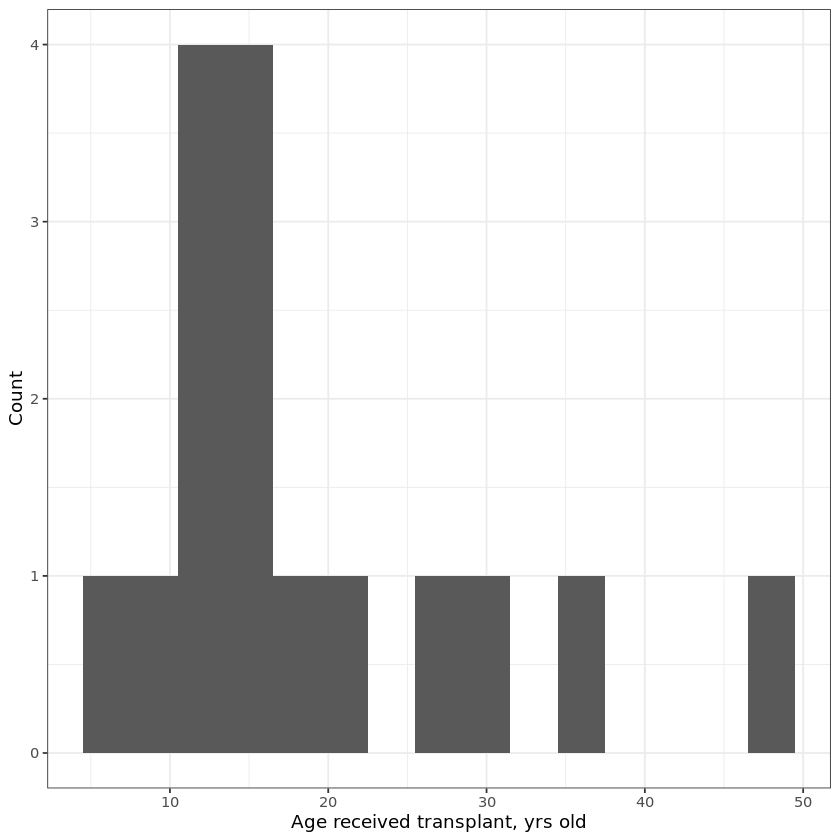

In [25]:
names(my_df)[2] <- "age_at_transplant" # Rename long column to age_at_transplant
ggplot(data = my_df) +
    geom_histogram(mapping = aes(x=age_at_transplant), bins=15) +
    labs(x = "Age received transplant, yrs old", y = "Count") +
    theme_bw()